In [83]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from eval_util import make_compare_plot,plot_cdf,plot_pdf,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering,convert_type
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import glob
%matplotlib inline

In [12]:
def plot_pdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)

    plt.plot(bins_count[1:], pdf, label=label)

def plot_cdf(data,label,bin=10):
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label=label)

def make_compare_plot(datasets,col_name, function, names, title, dataset, additional=""):
    for i in range(len(datasets)):
        data = datasets[i]
        function(data[col_name],names[i])
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig("evaluation_result/{}/{}_{}.png".format(dataset,title,additional))
    plt.show()



In [84]:
dataname = "news"
datapath = "dataset"
generated = "{}/generated/{}/".format(datapath,dataname)


data_origin = pd.read_csv("{}/origin/{}.csv".format(datapath,dataname))

#datalist = ["ctgan","tablegan","octgan","VAE","KL_daisy","sel_daisy","sm_daisy","selgan"]


ctgan = pd.read_csv("{}/generated/{}/ctgan/ctgan_less_300.csv".format(datapath,dataname))
ctgan_full = pd.read_csv("{}/generated/{}/ctgan/ctgan_full_300.csv".format(datapath,dataname))

if (dataname =="adult") or  (dataname =="credit"):
    tablegan = pd.read_csv("{}/generated/{}/tablegan/tablegan_{}_fake.csv".format(datapath,dataname,dataname))

if not dataname == "ticket":
    octgan = pd.read_csv("{}/generated/{}/octgan/octgan_{}.csv".format(datapath,dataname,dataname))
    
VAE = pd.read_csv("{}/generated/{}/VAE/sample_data_vae_800_0.csv".format(datapath,dataname,dataname)).set_axis(data_origin.columns, axis=1, inplace=False)
KL_daisy = pd.read_csv("{}/generated/{}/KL/KL_1_800_0.csv".format(datapath,dataname,dataname))

selgan = pd.read_csv("{}/generated/{}/selgan/selgan_300_less_batch.csv".format(datapath,dataname))
sel_daisy = pd.read_csv("{}/generated/{}/sel/sel_1_800_0.csv".format(datapath,dataname,dataname))
sm_daisy = pd.read_csv("{}/generated/{}/sel_mean/sel_mean_1_800_0.csv".format(datapath,dataname,dataname))



In [4]:
save_path = "evaluation_result/{}".format(dataname)
try:
    os.mkdir(save_path)
except:
    pass

In [5]:
octgan

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,617.941258,10.009772,-51.760995,0.788082,0.992904,0.839242,5.876347,2.545468,0.514894,0.983651,...,0.250963,0.801379,-0.516664,-0.400874,-0.490324,0.000096,0.000900,0.497250,-0.000279,1255.466864
1,103.332905,10.003514,-229.682090,-0.051555,-0.106714,0.026773,-4.003920,-0.031122,-0.795499,0.981308,...,-0.002224,0.002634,-0.014130,0.000696,0.009318,0.958738,-0.518225,0.495751,0.381216,3710.613116
2,81.539275,11.009737,949.326651,0.404074,0.996622,0.514875,7.327406,4.904272,7.852783,8.447168,...,0.099555,0.799803,-0.305619,-0.692244,-0.049879,0.000797,-0.000338,0.499561,-0.000310,18935.572834
3,421.944997,7.000716,559.641591,0.588850,0.999074,0.717381,43.507022,19.462294,5.798916,3.104852,...,0.141536,0.999565,-0.231985,-0.501780,-0.041650,0.993219,-0.000569,0.498528,-0.000739,2896.207135
4,381.464537,10.008373,920.472396,0.454477,0.992837,0.608160,16.946636,0.031379,10.488948,-0.007772,...,0.053187,0.799251,-0.330458,-0.501071,-0.100691,0.387178,-0.356302,0.103894,0.271267,1052.818747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,25.893205,8.012764,361.991997,0.629087,0.997090,0.759104,6.995196,3.994437,0.588878,-0.002447,...,0.099096,0.599802,-0.155387,-0.207292,-0.124986,0.989738,-0.000224,0.499555,-0.001207,567.730546
39640,391.565232,7.029328,86.487316,0.581233,0.996072,0.681897,6.389437,1.760370,1.116881,1.987587,...,0.099199,1.000460,-0.247789,-0.172840,-0.225911,-0.001982,-0.001513,0.498802,-0.000681,9559.855732
39641,87.895077,10.003246,419.096279,0.535425,0.996828,0.641767,45.698847,3.999575,1.218747,0.987034,...,0.051700,0.799966,-0.316762,-0.596989,-0.055237,0.473303,0.139750,0.036511,0.086787,5628.065706
39642,281.062953,11.005510,282.010373,0.603385,0.996029,0.735706,15.220319,4.972532,1.111407,-0.003749,...,0.032153,0.999213,-0.192382,-0.160636,-0.171208,0.292391,0.987651,0.000210,0.995146,7651.347146


In [6]:
def mode_collapse(datalist,namelist):
    for i in range(len(datalist)):
        data = datalist[i]
        name = namelist[i]
        print(name, (data.shape[0] - data.drop_duplicates().shape[0])/(data.shape[0])*100)

mode_collapse([ctgan,selgan,octgan,VAE],["ctgan","selgan","octgan","VAE"])

ctgan 0.0
selgan 0.0
octgan 0.0
VAE 0.0


In [7]:
data_origin.columns

Index([' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_p

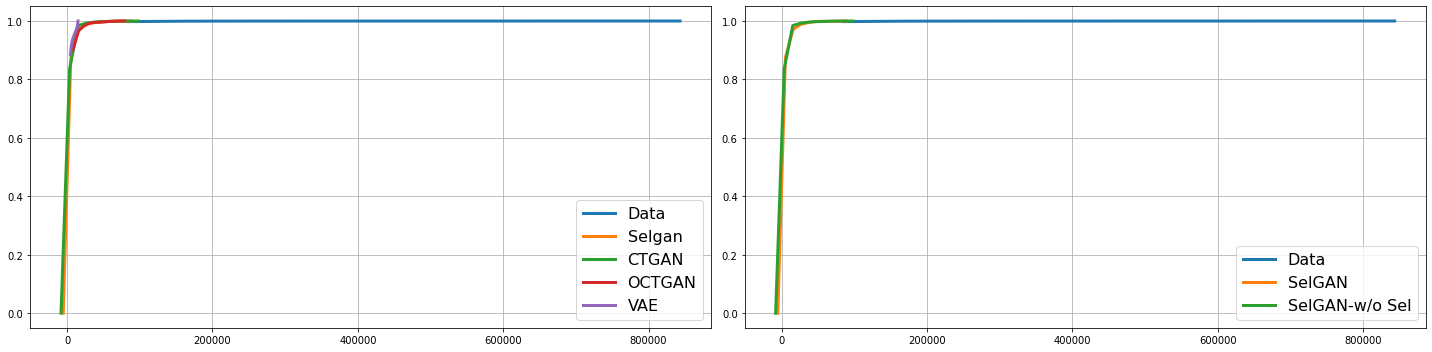

In [8]:
import matplotlib.font_manager as font_manager

column_name = " shares"
datasetleft = [data_origin, selgan, ctgan, octgan, VAE]
datanameleft = ["Data", "Selgan","CTGAN", "OCTGAN", "VAE"]
datasetright = [data_origin, selgan, ctgan]
datanameright = ["Data", "SelGAN", "SelGAN-w/o Sel"]

fig, (axs1,axs2) = plt.subplots(1,2, figsize = (20,5))

font = font_manager.FontProperties(
                                   #family='Comic Sans MS',
                                   #weight='bold',
                                   #style='normal', 
                                    size=16)


for i in range(len(datasetleft)):
    data = datasetleft[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs1.plot(bins_count[1:], cdf, label=datanameleft[i],linewidth=3)

for i in range(len(datasetright)):
    data = datasetright[i][column_name]
    count, bins_count = np.histogram(data, bins=10)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs2.plot(bins_count[1:], cdf, label=datanameright[i],linewidth=3)
    
axs1.legend(prop=font)
axs1.grid()
axs2.legend(prop=font)
axs2.grid()
fig.tight_layout()
        
    
# plt.subplots_adjust(left=0.1,
#                     bottom = 0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.1)

plt.savefig("evaluation_result/{}/CDF_{}.png".format(dataname,column_name))

In [9]:
column_name = " title_sentiment_polarity"

make_compare_plot([data_origin,ctgan,selgan, octgan],column_name,
plot_pdf,["Data", "ctgan","selgan", "octgan"],"{} PDF Distribution".format(column_name),dataname,"full",False)
make_compare_plot([data_origin,ctgan, selgan, octgan],column_name,
plot_cdf,["Data", "ctgan","selgan", "octgan"],"{} CDF Distribution".format(column_name),dataname,"full",False)

make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy"],"{} PDF Distribution".format(column_name),dataname,"Daisy",False)
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_cdf,["Data", "KL_daisy", "sel_daisy"],"{} CDF Distribution".format(column_name),dataname,"Daisy",False)

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name),dataname,"selgan",False)
make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_cdf,["Data", "ctgan", "Selgan"],"{} CDF Distribution".format(column_name),dataname,"selgan",False)

TypeError: make_compare_plot() takes from 6 to 7 positional arguments but 8 were given

In [ ]:
column_name = " title_sentiment_polarity"


make_compare_plot([data_origin,ctgan,selgan, octgan],column_name,
plot_pdf,["Data", "ctgan","selgan", "octgan"],"{} PDF Distribution".format(column_name),dataname,"full")
make_compare_plot([data_origin,ctgan, selgan, octgan],column_name,
plot_cdf,["Data", "ctgan","selgan", "octgan"],"{} CDF Distribution".format(column_name),dataname,"full")

make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_pdf,["Data", "KL_daisy", "sel_daisy"],"{} PDF Distribution".format(column_name),dataname,"Daisy")
make_compare_plot([data_origin, KL_daisy, sel_daisy],column_name,
plot_cdf,["Data", "KL_daisy", "sel_daisy"],"{} CDF Distribution".format(column_name),dataname,"Daisy")

make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_pdf,["Data", "ctgan", "selgan"],"{} PDF Distribution".format(column_name),dataname,"selgan")
make_compare_plot([data_origin, ctgan, selgan],column_name,
plot_cdf,["Data", "ctgan", "Selgan"],"{} CDF Distribution".format(column_name),dataname,"selgan")

In [ ]:
#Distance between NMI matrices
dataset = [data_origin,ctgan,selgan,octgan,VAE,KL_daisy,sel_daisy,sm_daisy]

distance_NMI = {}

from sklearn.metrics.cluster import normalized_mutual_info_score
for col in ['slope','wild_area', 'soil_type', 'cover_type']:
    
    mylist = []
    for data in dataset:
        A = data_origin[col].sample(n=5000, random_state=1)
        B = data[col].sample(n=5000, random_state=1)
        mylist.append(normalized_mutual_info_score(A,B))
    distance_NMI[col] = mylist
        

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score([1,2,3,4,5], [5,4,3,2,1])



In [ ]:
distance_NMI_df = pd.DataFrame(distance_NMI,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])
distance_NMI_df.to_csv("evaluation_result/{}/distance_NMI.csv".format(dataname),index = False)

In [ ]:
distance_NMI_df

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch
import seaborn as sns

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [ ]:
VAE = VAE.dropna()

In [ ]:
f,axs = plt.subplots(2,3,figsize = (12,7))

sns.heatmap(data_origin[useful].corr(),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,0])
axs[0, 0].set_title('Origin Data', fontsize=20)

sns.heatmap((selgan[useful].corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,1])
axs[0, 1].set_title('SelGAN', fontsize=20)

sns.heatmap((ctgan[useful].corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[0,2])
axs[0, 2].set_title('CTGAN', fontsize=20)

sns.heatmap((octgan[useful].corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,0])
axs[1, 0].set_title('OCTGAN', fontsize=20)

# sns.heatmap((tablegan.corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
# axs[1, 1].set_title('tableGAN', fontsize=20)

sns.heatmap((VAE[useful].corr()),cmap='Blues', yticklabels=False,xticklabels=False, cbar=False, ax = axs[1,1])
axs[1, 1].set_title('VAE', fontsize=20)

axs[1][2].set_visible(False)

axs[1][0].set_position([0.24,0.125,0.228,0.343])
axs[1][1].set_position([0.55,0.125,0.228,0.343])

plt.savefig("evaluation_result/{}/CompleteHeatmap.png".format(dataname,"Origin Data"))
plt.show()


In [ ]:
useful = [' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords',
       ' self_reference_max_shares', ' self_reference_avg_sharess', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_title_subjectivity',
       ' abs_title_sentiment_polarity', ' shares']

In [ ]:
print("octgan",abs(data_origin[useful].corr() - octgan[useful].corr()).sum().sum())
print("selgan",abs(data_origin[useful].corr() - selgan[useful].corr()).sum().sum())
print("ctgan",abs(data_origin[useful].corr() - ctgan[useful].corr()).sum().sum())
#print("tablegan",abs(data_origin.corr() - tablegan.corr()).sum().sum())
print("vae",abs(data_origin[useful].corr() - VAE[useful].corr()).sum().sum())


In [ ]:
sns.heatmap(data_origin.corr(),cmap='Blues')
plt.title("{} Correlation Heat Map".format("Origin Data"))
#plt.show()
plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"Origin Data"))
plt.show()

sns.heatmap((ctgan_full.corr()),cmap='Blues')
plt.title("{} Correlation Heat Map".format("CTGAN"))
plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"CTGAN"))
plt.show()
sns.heatmap((selgan.corr()),cmap='Blues')
plt.title("{} Correlation Heat Map".format("SelGAN"))
plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"Selgan"))
plt.show()
# sns.heatmap((selgan_full.corr()),cmap='Blues')
# plt.title("{} Correlation Heat Map".format("SelGAN_full"))
# plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"Selgan_"))
# plt.show()
sns.heatmap((octgan.corr()),cmap='Blues')
plt.title("{} Correlation Heat Map".format("OCTGAN"))
plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"OCTGAN"))
plt.show()
plt.show()
# sns.heatmap((tablegan.corr()),cmap='Blues')
# plt.title("{} Correlation Heat Map".format("tableGAN"))
# plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"tableGAN"))
# plt.show()
# plt.show()
# sns.heatmap((KL_daisy.corr()),cmap='Blues')
# plt.savefig("evaluation_result/{}/{} Correlation Heat Map.png".format(dataname,"Daisy"))
# plt.show()

## Evaluation

In [ ]:
ctgan

In [ ]:
# categoricals = config["one-hot_cols"]
# ordinals = config["ordinal_cols"]


# data_origin["label"] = "data"


# ctgan["label"] = "ctgan"
# selgan["label"] = "selgan"
# octgan["label"] = "octgan"
# VAE["label"] = "VAE"

# KL_daisy["label"] = "KL"
# sel_daisy["label"] = "sel"
# sm_daisy["label"] = "sm"#### Split train and test

In [ ]:
# full = pd.concat([data_origin,ctgan,selgan,octgan,VAE,KL_daisy,sel_daisy,sm_daisy])
# full = full[data_origin.columns]
# full = convert_type(full,sorted(categoricals+ordinals))

In [ ]:
# data_origin = full[full["label"] == "data"]

# ctgan = full[full["label"] == "ctgan"]
# selgan = full[full["label"] == "selgan"]
# octgan = full[full["label"] == "octgan"]

# VAE = full[full["label"] == "VAE"]
# KL_daisy = full[full["label"] == "KL"]
# sel_daisy = full[full["label"] == "sel"]
# sm_daisy = full[full["label"] == "sm"]


In [ ]:
data_origin

In [ ]:
# categoricals = config["one-hot_cols"]
# ordinals = config["ordinal_cols"]


# data_origin["label"] = "data"


# ctgan["label"] = "ctgan"
# selgan["label"] = "selgan"
# octgan["label"] = "octgan"
# tablegan["label"] = "tablegan"
# VAE["label"] = "VAE"

# KL_daisy["label"] = "KL"
# sel_daisy["label"] = "sel"
# sm_daisy["label"] = "sm"

In [85]:
data_origin_droped = data_origin.astype("float64")
origin_np = np.array(data_origin_droped)
col = list(data_origin_droped.columns)
indices = numpy.random.permutation(data_origin.shape[0])
n = int(data_origin.shape[0] * 0.3)
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)
#training_data = training_data.drop(columns=["label","fnlwgt","income"]).astype("float64")

In [87]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

def make_prediction(response, response_type,training_data, test, dataset, clf):

    f1 = []
    auc = []
    mse = []
    result = []

    train_data_y = training_data[response].astype("int64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("int64")


    clf.fit(train_data_X, train_data_y)
    pred_data_y = clf.predict(test_data_X)
    result.append(clf.score(test_data_X,test_data_y))
    
    
    if response_type == "clf":
        f1.append(f1_score(test_data_y, pred_data_y
                           ,average='weighted'))
        
    else:
        mse.append(((pred_data_y-test_data_y)**2).mean())


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response]).astype("float64")
        train_y = data[response].astype("int64")
        
        #try:
        clf.fit(train_X, train_y)
        pred_data_y = clf.predict(test_data_X)
        #except:
        #    result.append(np.nan)
            
        if response_type == "clf":
            result.append(clf.score(test_data_X,test_data_y))
            f1.append(f1_score(test_data_y, pred_data_y
                               ,average='weighted'))      
            
        else:
            result.append(clf.score(test_data_X,test_data_y))
            mse.append(((pred_data_y-test_data_y)**2).mean())

    if response_type == "clf":       
        return result,f1
    else:
        return result,mse

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR

from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier


xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_reg = xgb.XGBRegressor(eval_metric='mlogloss')

rf_clf = RandomForestClassifier(n_jobs = -1)
rf_reg = RandomForestRegressor(n_jobs = -1)

svm_clf = LinearSVC()
svm_reg = LinearSVR()

gb_clf = GradientBoostingClassifier()
gb_reg = GradientBoostingRegressor()



In [ ]:
# data_origin_droped = data_origin.astype("float64")
# origin_np = np.array(data_origin_droped)
# col = list(data_origin_droped.columns)
# indices = numpy.random.permutation(data_origin.shape[0])
# n = int(data_origin.shape[0] * 0.3)
# test_idx, training_idx = indices[:n], indices[n:]
# training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)

In [88]:
#dataset = [ctgan,selgan,octgan,tablegan,VAE,KL_daisy,sel_daisy,sm_daisy]
dataset = [ctgan,selgan,octgan,VAE]
dataset = [KL_daisy,KL_daisy,sm_daisy]
#dataset = [ctgan]

In [89]:
acc_xgb, f1_xgb = make_prediction(" is_weekend", "clf",training_data, test,dataset,gb_clf)
acc_rf, f1_rf = make_prediction(" is_weekend","clf",training_data, test,dataset,rf_clf)
acc_svm, f1_svm = make_prediction(" is_weekend", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 3/3 [00:19<00:00,  6.66s/it]


In [90]:
f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
f1["avg"] = f1.mean(axis=1)
f1

,XGB,RF,SVM,avg
Origin,1.000000,1.000000,0.309872,0.769957
KL_Daisy,0.730312,0.774752,0.670319,0.725128
Sel-Daisy,0.727446,0.781036,0.669862,0.726115
SM_Daisy,0.727086,0.791447,0.754863,0.757799


In [26]:
ct_f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
ct_f1["avg"] = ct_f1.mean(axis=1)

ct_acc = pd.DataFrame({"XGB":acc_xgb,"RF":acc_rf,"SVM":acc_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
ct_acc["avg"] = ct_acc.mean(axis=1)

In [27]:
ct_f1

,XGB,RF,SVM,avg
Origin,1.000000,1.000000,0.808580,0.936193
CTGAN,0.810767,0.811522,0.810767,0.811019
Selgan,0.811049,0.810851,0.798085,0.806662
octgan,0.995244,1.000000,0.810173,0.935139
VAE,0.810851,0.810851,0.810851,0.810851


In [37]:
acc_xgb, f1_xgb = make_prediction(" data_channel_is_lifestyle", "clf",training_data, test,dataset,gb_clf)
acc_rf, f1_rf = make_prediction(" data_channel_is_lifestyle","clf",training_data, test,dataset,rf_clf)
acc_svm, f1_svm = make_prediction(" data_channel_is_lifestyle", "clf",training_data, test,dataset,svm_clf)

100%|██████████| 4/4 [01:00<00:00, 15.07s/it]


In [ ]:
#lf_f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
lf_f1["avg"] = lf_f1.mean(axis=1)

# #lf_acc = pd.DataFrame({"XGB":acc_xgb,"RF":acc_rf,"SVM":acc_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
# lf_acc["avg"] = lf_acc.mean(axis=1)

In [68]:
#lf_f1 = pd.DataFrame({"XGB":f1_xgb,"RF":f1_rf,"SVM":f1_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
lf_f1["avg"] = lf_f1.mean(axis=1)

# #lf_acc = pd.DataFrame({"XGB":acc_xgb,"RF":acc_rf,"SVM":acc_svm},index = ["Origin","CTGAN","Selgan","octgan","VAE"])
# lf_acc["avg"] = lf_acc.mean(axis=1)

[0.3098724556120932, 0.670318543967416, 0.6698618728660127, 0.7548634447620872]

In [71]:
lf_f1.to_csv("n_liftstyle_f1.csv")

In [91]:
shr_r2_xgb, shr_mse_xgb = make_prediction(" shares", "reg",training_data, test,dataset,xgb_reg)
shr_r2_rf, shr_mse_rf = make_prediction(" shares", "reg",training_data, test,dataset,rf_reg)
shr_r2_svm, shr_mse_svm = make_prediction(" shares", "reg",training_data, test,dataset,svm_reg)

100%|██████████| 3/3 [00:38<00:00, 12.73s/it]


In [93]:
sp = pd.DataFrame({"XGB":shr_mse_xgb,"RF":shr_mse_rf,"SVM":shr_mse_svm},index = ["Origin","KL_Daisy","Sel-Daisy","SM_Daisy"])
sp["avg"] = sp.mean(axis=1)
sp


,XGB,RF,SVM,avg
Origin,113776392.0,8.443273e+07,9.712142e+07,9.844352e+07
KL_Daisy,78192496.0,7.783409e+07,9.831443e+07,8.478034e+07
Sel-Daisy,78192496.0,7.770495e+07,9.864952e+07,8.484899e+07
SM_Daisy,79319144.0,7.928784e+07,1.207905e+08,9.313251e+07


In [94]:
(sp/10000000)

,XGB,RF,SVM,avg
Origin,11.377639,8.443273,9.712142,9.844352
KL_Daisy,7.819250,7.783409,9.831443,8.478034
Sel-Daisy,7.819250,7.770495,9.864952,8.484899
SM_Daisy,7.931914,7.928784,12.079055,9.313251


In [ ]:
prediction["timedelta"] = make_prediction(" timedelta", "reg",training_data, test, dataset)
prediction["n_tokens_title"] = make_prediction(" n_tokens_title", "reg",training_data, test, dataset)
prediction["n_tokens_content"] = make_prediction(" n_tokens_content", "reg",training_data, test, dataset)
prediction["n_unique_tokens"] = make_prediction(" n_unique_tokens", "reg",training_data, test, dataset)

prediction["n_non_stop_words"] = make_prediction(" n_non_stop_words", "reg",training_data, test, dataset)
prediction["n_non_stop_unique_tokens"] = make_prediction(" n_non_stop_unique_tokens", "reg",training_data, test, dataset)
prediction["num_hrefs"] = make_prediction(" num_hrefs", "reg",training_data, test, dataset)

prediction["num_self_hrefs"] = make_prediction(" num_self_hrefs", "reg",training_data, test, dataset)
prediction["num_imgs"] = make_prediction(" num_imgs", "reg",training_data, test, dataset)
prediction["num_videos"] = make_prediction(" num_videos", "reg",training_data, test, dataset)


prediction["average_token_length"] = make_prediction(" average_token_length", "reg",training_data, test, dataset)
prediction["num_keywords"] = make_prediction(" num_keywords", "reg",training_data, test, dataset)


In [ ]:
prediction = {}
prediction["data_channel_is_lifestyle"],prediction["data_channel_is_lifestyle_f1"] = make_prediction(" data_channel_is_lifestyle", "clf",training_data, test, dataset)
prediction["data_channel_is_entertainment"],prediction["data_channel_is_entertainment_f1"] = make_prediction(" data_channel_is_entertainment", "clf",training_data, test, dataset)
prediction["data_channel_is_bus"],prediction["data_channel_is_bus_f1"] = make_prediction(" data_channel_is_bus", "clf",training_data, test, dataset)
prediction["data_channel_is_socmed"],prediction["data_channel_is_socmed_f1"] = make_prediction(" data_channel_is_socmed", "clf",training_data, test, dataset)
prediction["data_channel_is_tech"],prediction["data_channel_is_tech_f1"] = make_prediction(" data_channel_is_tech", "clf",training_data, test, dataset)
prediction["data_channel_is_world"],prediction["data_channel_is_world_f1"] = make_prediction(" data_channel_is_world", "clf",training_data, test, dataset)


In [ ]:

[" max_positive_polarity"," abs_title_sentiment_polarity"]
ML_result = pd.DataFrame(prediction,index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'])

In [ ]:
#ML_result[["workclass","relationship","sex"]]
ML_result

its:7 col
full:7 col

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
def make_prediction_rf(response, response_type,training_data, test, dataset):

    result = []

    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response]).astype("float64")

    test_data_X = test.drop(columns=[response]).astype("float64")
    test_data_y = test[response].astype("float64")


    if response_type == "clf":

        #clf = xgb.XGBClassifier(eval_metric='mlogloss')
        clf = RandomForestClassifier(random_state=0)

    else:

        clf = RandomForestRegressor(random_state=0)

    clf.fit(train_data_X, train_data_y)
    result.append(clf.score(test_data_X,test_data_y))


    for data in tqdm(dataset):

        train_X = data.drop(columns=[response,"label","fnlwgt"]).astype("float64")
        train_y = data[response].astype("float64")
        
        try:
            clf.fit(train_X, train_y)
            result.append(clf.score(test_data_X,test_data_y))
        except:
            result.append(np.nan)

    return result

In [ ]:
prediction_rf = {}
prediction_rf["age"] = make_prediction("age", "reg",training_data, test, dataset)
prediction_rf["workclass"] = make_prediction("workclass", "clf",training_data, test, dataset)
prediction_rf["education"] = make_prediction("education", "clf",training_data, test, dataset)
prediction_rf["education_num"] = make_prediction("education-num", "reg",training_data, test,dataset)
prediction_rf["marital_status"] = make_prediction("marital-status", "clf",training_data, test,dataset)
prediction_rf["occupation"] = make_prediction("occupation", "clf",training_data, test,dataset)
prediction_rf["relationship"] = make_prediction("relationship", "clf",training_data, test,dataset)
prediction_rf["race"] = make_prediction("race", "clf",training_data, test,dataset)
prediction_rf["sex"] = make_prediction("sex", "clf",training_data, test,dataset)
prediction_rf["capital_gain"] = make_prediction("capital-gain", "reg",training_data, test,dataset)
prediction_rf["capital_loss"] = make_prediction("capital-loss", "reg",training_data, test,dataset)
prediction_rf["hours_per_week"] = make_prediction("hours-per-week", "reg",training_data, test,dataset)
prediction_rf["native_country"] = make_prediction("native-country", "reg",training_data, test,dataset)
prediction_rf["income"] = make_prediction("income", "clf",training_data, test,dataset)

In [ ]:
def make_clustering(training_data,test,dataset,n = 5):
    NMI = []

    train_data_x = training_data.astype("float64")

    test_data_X = test.astype("float64")
    
    kmeans = KMeans(n_clusters=n,random_state = 0).fit(train_data_x)

    ground_truth = kmeans.predict(test_data_X)

    NMI.append(normalized_mutual_info_score(ground_truth, ground_truth))
    #print(train_data_x.columns)

    for data in tqdm(dataset):
        data = data.astype("float64")
        #print(data.columns)
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        result = kmeans.predict(test_data_X)
        NMI.append(normalized_mutual_info_score(ground_truth, result))




    return NMI
### Clustering

In [ ]:
## Unsupervised Machine learning task 

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
pd.DataFrame(make_clustering(training_data,test,dataset,n=5),index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'],columns=["Clustering NMI"])

In [ ]:
pd.DataFrame(make_clustering(training_data,test,dataset,n=7),index=["ground Truth",'ctgan','selgan','octgan','VAE','KL_daisy','sel_daisy','sm_daisy'],columns=["Clustering NMI"])

In [ ]:
training_data["Class"].value_counts()

## Loss 

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/full/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_full training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_cate/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_cate_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/weak_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('weak_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [ ]:
data_log = pd.read_csv("dataset/generated/strong_num/its/train_log.txt",
names=["epoch","time","G_origin","G_mean","G_fd","G_KL","G_sel"])
data_log["G_total"] = data_log["G_origin"] + data_log["G_mean"] + data_log["G_fd"] + data_log["G_KL"] + data_log["G_sel"]

fig, axs = plt.subplots(3,2,figsize = (9,6))
fig.suptitle('strong_num_its training log')

axs[0][0].plot(data_log["G_total"])
axs[0][0].set_title("G_total")
axs[0][1].plot(data_log["G_origin"])
axs[0][1].set_title("G_origin")

axs[1][0].plot(data_log["G_mean"])
axs[1][0].set_title("G_mean")
axs[1][1].plot(data_log["G_KL"])
axs[1][1].set_title("G_KL")

axs[2][0].plot(data_log["G_fd"])
axs[2][0].set_title("G_fd")
axs[2][1].plot(data_log["G_sel"])
axs[2][1].set_title("G_sel")

for ax in axs.flat:
    ax.set(xlabel='times', ylabel='loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.show()

### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [ ]:
len(dataset)

In [ ]:
similar = hitting_rate(dataset)

In [ ]:
maxi,mini = DCR(dataset)


In [ ]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num_its","Weak-Num_its","Strong-Cate_its","Weak-Cate_its","Strong-Num_full","Weak-Num_full","Strong-Cate_full","Weak-Cate_full"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])